In [1]:
import os
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt

# from torch.serialization import add_safe_globals
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
import neuralop as nop
from neuralop.models import FNO
# from neuralop.layers.spectral_convolution import SpectralConv

# add_safe_globals([torch._C._nn.gelu, SpectralConv])

# 1. Load dataset.mat files
data_dir = 'dataset/data/tapered_seal'
mat_file = os.path.join(data_dir, '20250812_T_113003', 'dataset.mat')

# 파라미터 설정
batch_size = 2**10
criterion = nop.losses.LpLoss(d=1, p=2)
epochs = 1000
param_embedding_dim = 64
fno_modes = 16
fno_hidden_channels = 128
n_layers = 4
shared_out_channels = fno_hidden_channels
lr = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
weight_decay=1e-4

import json

hyperparams = {
    "Batch size": batch_size,
    "Parameter embedding dimension": param_embedding_dim,
    "# of FNO modes": fno_modes,
    "# of FNO hidden channels": fno_hidden_channels,
    "# of FNO layers": n_layers,
    "# of shared output channels": shared_out_channels,
    "Learning rate": f"{lr:.1e}"
}

print(json.dumps(hyperparams, indent=2))

# 데이터 로딩 및 전처리
with h5py.File(mat_file, 'r') as mat:
    # inputNond: [nPara, nData] 형상 파라미터
    input_nond = np.array(mat.get('inputNond'))
    # wVec: [1, nVel] 회전 속도 벡터 (좌표 그리드)
    w_vec = np.array(mat['params/wVec'])
    # RDC: [6, nVel, nData] 동특성 계수 (타겟 함수)
    rdc = np.array(mat.get('RDC'))

    n_para, n_data = input_nond.shape
    _, n_vel = w_vec.shape
    n_rdc_coeffs = rdc.shape[0] # 6 (K, k, C, c, M, m)

    # 입력 데이터 (X): 형상 파라미터 [nData, nPara]
    X_params = input_nond.T

    # 출력 데이터 (y): 동특성 계수 함수 [nData, nVel, nRDC]
    # FNO는 (batch, channels, grid_points) 형태를 선호하므로 [nData, nRDC, nVel]로 변경이라고 GPT가 그럔다
    y_functions = rdc.transpose(2, 0, 1) # [nData, nRDC, nVel]

    # 회전 속도 그리드: [nVel, 1]
    
    w = w_vec.squeeze()                         # [n_vel]
    w_norm = 2 * (w - w.min()) / (w.max()-w.min()) - 1.0 # normalization
    grid = w_norm[:, None] # [nVel, 1]



Using device: cuda
{
  "Batch size": 1024,
  "Parameter embedding dimension": 64,
  "# of FNO modes": 16,
  "# of FNO hidden channels": 128,
  "# of FNO layers": 4,
  "# of shared output channels": 128,
  "Learning rate": "1.0e-03"
}


In [2]:
# # 데이터 스케일링
# scaler_X = StandardScaler()
# X_scaled = scaler_X.fit_transform(X_params) 

# scalers_y = [StandardScaler() for _ in range(n_rdc_coeffs)]
# y_scaled_channels = []
# for i in range(n_rdc_coeffs):
#     # 각 채널(RDC)의 데이터를 [n_data * n_vel, 1] 형태로 만들어 스케일러에 적용
#     channel_data = y_functions[:, i, :].reshape(-1, 1)
#     scaled_channel_data = scalers_y[i].fit_transform(channel_data)
#     # 원래 형태 [n_data, n_vel]로 복원
#     y_scaled_channels.append(scaled_channel_data.reshape(n_data, n_vel))

# # 스케일링된 채널들을 다시 [n_data, n_rdc_coeffs, n_vel]
# y_scaled = np.stack(y_scaled_channels, axis=1)


indices = np.arange(n_data)
train_size = int(n_data*0.7); val_size = int(n_data*0.15)
test_size = n_data - train_size - val_size
train_idx, val_idx, test_idx = np.split(np.random.permutation(indices),
                                        [train_size, train_size+val_size])

scaler_X = StandardScaler().fit(X_params[train_idx])
X_scaled = np.empty_like(X_params, dtype=float)
X_scaled[train_idx] = scaler_X.transform(X_params[train_idx])
X_scaled[val_idx]  = scaler_X.transform(X_params[val_idx])
X_scaled[test_idx] = scaler_X.transform(X_params[test_idx])

scalers_y = [StandardScaler().fit(y_functions[train_idx, i, :].reshape(-1,1))
             for i in range(n_rdc_coeffs)]

y_scaled = np.empty_like(y_functions, dtype=float)
for i in range(n_rdc_coeffs):
    for split_idx in (train_idx, val_idx, test_idx):
        y_scaled[split_idx, i, :] = scalers_y[i].transform(
            y_functions[split_idx, i, :].reshape(-1,1)
        ).reshape(-1, y_functions.shape[-1])

# Torch 텐서로 변환
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
# y_tensor = torch.tensor(y_scaled, dtype=torch.float32).unsqueeze(1)
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# 데이터셋 및 데이터로더 생성
dataset = TensorDataset(X_tensor, y_tensor)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class ParametricFNO(nn.Module):
    """
    기존: 형상 파라미터를 조건으로 받아 함수를 예측하는 FNO 모델 (단일 네트워크)
    outputs: [B, out_channels, n_vel]
    """
    def __init__(self, n_params, param_embedding_dim, fno_modes, fno_hidden_channels, in_channels, out_channels,n_layers):
        super().__init__()
        self.n_params = n_params
        self.param_encoder = nn.Sequential(
            nn.Linear(n_params, param_embedding_dim),
            nn.ReLU(),
            nn.Linear(param_embedding_dim, param_embedding_dim)
        )
        self.fno = FNO(
            n_modes=(fno_modes,),
            hidden_channels=fno_hidden_channels,
            n_layers=n_layers,
            in_channels=in_channels + param_embedding_dim,
            out_channels=out_channels
        )

    def forward(self, params, grid):
        # params: [B, n_params], grid: [B, n_vel, 1]
        pe = self.param_encoder(params)                      # [B, emb]
        pe = pe.unsqueeze(1).repeat(1, grid.shape[1], 1)    # [B, n_vel, emb]
        fno_in = torch.cat([grid, pe], dim=-1).permute(0, 2, 1)  # [B, 1+emb, n_vel]
        out = self.fno(fno_in)  # [B, out_channels, n_vel]
        return out
    
class MultiHeadParametricFNO(nn.Module):
    """
    FNO 본체는 공유하고, 채널별 1x1 Conv1d 헤드를 분리하는 멀티헤드 구조.
    outputs: [B, n_heads(=n_rdc_coeffs), n_vel]
    """
    def __init__(self, n_params, param_embedding_dim, fno_modes, fno_hidden_channels, in_channels, n_heads,n_layers, shared_out_channels):
        super().__init__()
        self.n_params = n_params
        self.param_encoder = nn.Sequential(
            nn.Linear(n_params, param_embedding_dim),
            nn.ReLU(),
            nn.Linear(param_embedding_dim, param_embedding_dim)
        )
        self.trunk = FNO(
            n_modes=(fno_modes,),
            hidden_channels=fno_hidden_channels,
            n_layers=n_layers,
            in_channels=in_channels + param_embedding_dim,
            out_channels=shared_out_channels
        )
        
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(shared_out_channels, shared_out_channels, 1),
                nn.GELU(),
                nn.BatchNorm1d(shared_out_channels),
                nn.Dropout(0.1),
                # depth 2
                nn.Conv1d(shared_out_channels, shared_out_channels // 2, 1),
                nn.GELU(),
                nn.BatchNorm1d(shared_out_channels // 2),
                nn.Dropout(0.1),
                # output
                nn.Conv1d(shared_out_channels // 2, 1, 1)
            ) for _ in range(n_heads)
        ])

    def forward(self, params, grid):
        pe = self.param_encoder(params)                       # [B, emb]
        pe = pe.unsqueeze(1).repeat(1, grid.shape[1], 1)     # [B, n_vel, emb]
        x = torch.cat([grid, pe], dim=-1).permute(0, 2, 1)   # [B, 1+emb, n_vel]
        feat = self.trunk(x)                                  # [B, Csh, n_vel]
        outs = [head(feat) for head in self.heads]            # each: [B,1,n_vel]
        return torch.cat(outs, dim=1)                         # [B, n_heads, n_vel]

optimizer = None
best_val_loss = float('inf')
base_dir = 'net'
os.makedirs(base_dir, exist_ok=True)


Training set size: 944
Validation set size: 202
Test set size: 204


In [3]:

model = MultiHeadParametricFNO(
    n_params=n_para,
    param_embedding_dim=param_embedding_dim,
    fno_modes=fno_modes,
    fno_hidden_channels=fno_hidden_channels,
    in_channels=1,
    n_heads=n_rdc_coeffs,
    n_layers=n_layers,
    shared_out_channels=shared_out_channels
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
model_save_path = os.path.join(base_dir, 'fno_seal_best_multihead.pth')

for epoch in range(epochs):
    model.train(); train_loss = 0.0
    for params, functions in train_loader:
        params, functions = params.to(device), functions.to(device)
        batch_grid = grid_tensor.unsqueeze(0).repeat(params.size(0), 1, 1).to(device)
        optimizer.zero_grad()
        outputs = model(params, batch_grid)
        loss = criterion(outputs, functions)
        loss.backward(); optimizer.step()
        train_loss += loss.item() * params.size(0)
    model.eval(); val_loss = 0.0
    with torch.no_grad():
        for params, functions in val_loader:
            params, functions = params.to(device), functions.to(device)
            batch_grid = grid_tensor.unsqueeze(0).repeat(params.size(0), 1, 1).to(device)
            outputs = model(params, batch_grid)
            val_loss += criterion(outputs, functions).item() * params.size(0)
    train_loss /= len(train_dataset); val_loss /= len(val_dataset)
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train {train_loss:.6f}, Val {val_loss:.6f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({'state_dict': model.state_dict()}, model_save_path)
    scheduler.step()

# --- Evaluate ---
ckpt = torch.load(model_save_path, map_location=device, weights_only=False)
sd = ckpt.get('state_dict', ckpt)
sd.pop('_metadata', None) 
missing = model.load_state_dict(sd, strict=False)
if missing.unexpected_keys:
    print("unexpected:", missing.unexpected_keys)
if missing.missing_keys:
    print("missing:", missing.missing_keys)
model.eval()

n_test_samples = len(test_dataset.indices)
test_params = X_tensor[test_dataset.indices].to(device)
grid_repeated = grid_tensor.unsqueeze(0).repeat(n_test_samples, 1, 1).to(device)


/opt/conda/lib/python3.11/site-packages/tltorch/factorized_tensors/factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.__class__(self.tensor[indices])
/opt/conda/lib/python3.11/site-packages/neuralop/layers/spectral_convolution.py:468: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out_ff

Epoch 50/1000, Train 1879.614990, Val 1159.563477
Epoch 100/1000, Train 1274.192139, Val 629.616089


KeyboardInterrupt: 

In [ ]:
# --- Validation on Test Set ---
model.eval()
test_params = X_tensor[test_dataset.indices].to(device)
test_targets = y_tensor[test_dataset.indices].to(device)
grid_repeated = grid_tensor.unsqueeze(0).repeat(len(test_dataset.indices), 1, 1).to(device)

with torch.no_grad(): # 예측하는 부분인듯
    preds_scaled = model(test_params, grid_repeated).cpu().numpy()
    targets_scaled = test_targets.cpu().numpy()

preds_tmp, targets_tmp = [], []
for i in range(n_rdc_coeffs):
    preds_tmp.append(  scalers_y[i].inverse_transform(preds_scaled[:, i, :]) )
    targets_tmp.append(scalers_y[i].inverse_transform(targets_scaled[:, i, :]) )

preds_orig   = np.stack(preds_tmp,   axis=1)
targets_orig = np.stack(targets_tmp, axis=1)


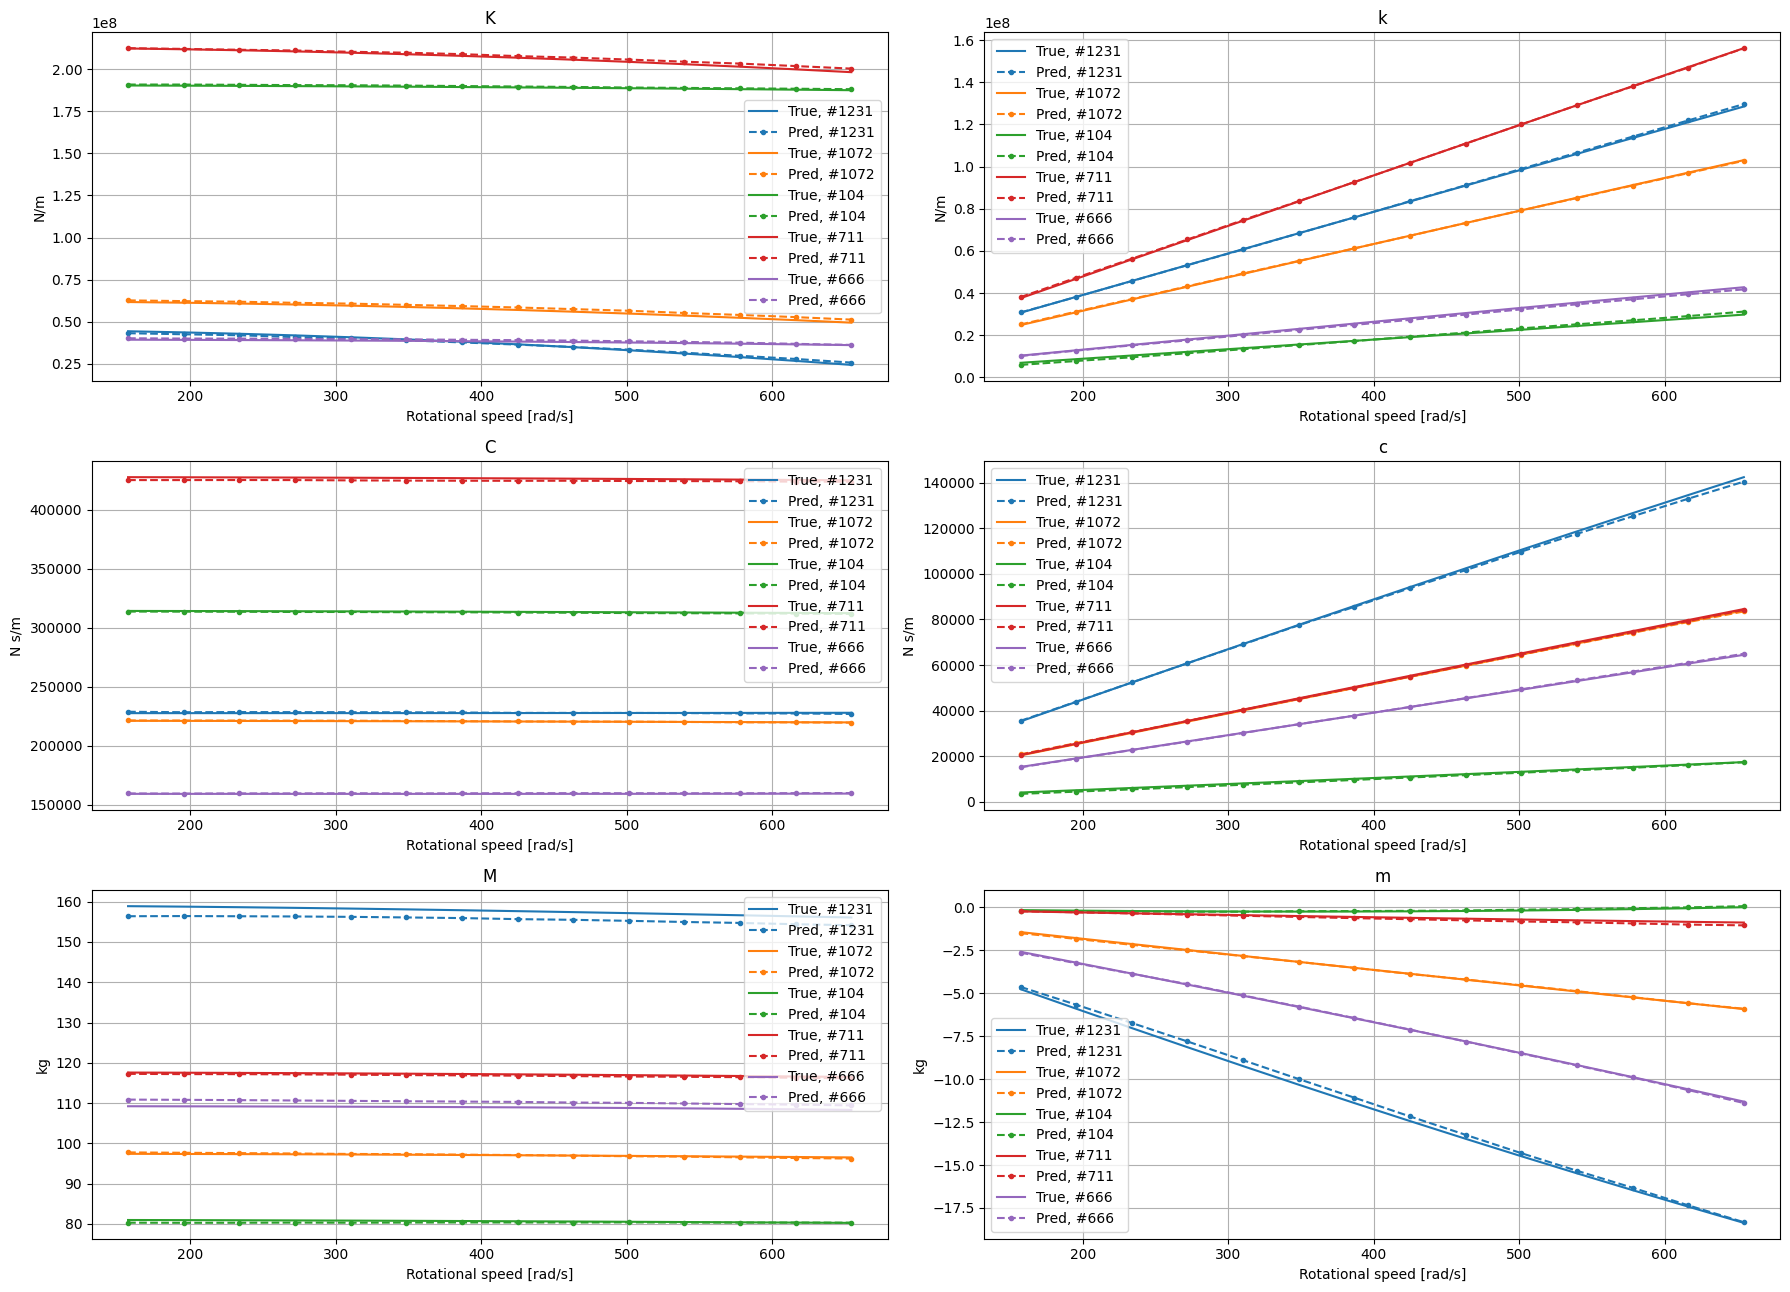

[K] RMSE: 1.98169e+06, MAE: 1.38067e+06, R^2: 0.999459, rRMSE: 0.5487%, MAPE: 1.7888%
[k] RMSE: 896986, MAE: 562744, R^2: 0.999627, rRMSE: 0.3295%, MAPE: 3.6853%
[C] RMSE: 3011.29, MAE: 1856.2, R^2: 0.999365, rRMSE: 0.5924%, MAPE: 0.7635%
[c] RMSE: 391.253, MAE: 278.019, R^2: 0.999829, rRMSE: 0.2242%, MAPE: 0.8927%
[M] RMSE: 0.924398, MAE: 0.619519, R^2: 0.999276, rRMSE: 0.6746%, MAPE: 0.4876%
[m] RMSE: 0.227693, MAE: 0.103254, R^2: 0.998947, rRMSE: 0.4255%, MAPE: 12.6092%
[Overall] RMSE: 888039, MAE: 324259, R^2: 0.999789, rRMSE: 0.2371%, MAPE: 3.3712%
Inference time for 204 samples: 0.005996 seconds
Average per sample: 0.000029 seconds


In [ ]:
# 샘플 시각화
import matplotlib.colors as mcolors
mcolors_list = list(mcolors.TABLEAU_COLORS.values())  # HEX 값 리스트
# mcolors_list = list(mcolors.CSS4_COLORS.values())  # HEX 값 리스트
rdc_labels = ['K', 'k', 'C', 'c', 'M', 'm']
rdc_units = ['N/m', 'N/m', 'N s/m', 'N s/m', 'kg', 'kg']
    
n_plot = 1
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()  # 2D -> 1D 배열로 변환

for j in range(n_rdc_coeffs):
    ax = axes[j]
    for idx in range(n_plot):
        color = mcolors_list[idx % len(mcolors_list)]
        ax.plot(w, targets_orig[idx, j, :], color=color, linestyle='-', 
                label=f"True, #{test_dataset.indices[idx]}")
        ax.plot(w, preds_orig[idx, j, :], color=color, linestyle='--', marker='o', markersize=3, 
                label=f"Pred, #{test_dataset.indices[idx]}")
    ax.set_xlabel('Rotational speed [rad/s]')
    ax.set_ylabel(f"{rdc_units[j]}")
    ax.set_title(f"{rdc_labels[j]}")
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=(0, 0.03, 1, 0.96))
plt.show()

# n_plot = 5
# for j in range(n_rdc_coeffs):
#     plt.figure(figsize=(8, 6))
#     for idx in range(n_plot):
#         color = mcolors_list[idx % len(mcolors_list)] 
#         plt.plot(w, targets_orig[idx,j,:], color=color, linestyle='-', label=f"True, #{test_dataset.indices[idx]}")
#         plt.plot(w, preds_orig[idx,j,:], color=color, linestyle='--', marker='o', markersize=3, label=f"Pred, #{test_dataset.indices[idx]}")
#     plt.legend()
#     plt.grid(True)
#     plt.xlabel('Rotational speed [rad/s]')
#     plt.ylabel(f"{rdc_units[j]}")
#     plt.title(f"{rdc_labels[j]}")
#     plt.tight_layout(rect=(0, 0.03, 1, 0.96)); plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for coeff_idx, label in enumerate(rdc_labels):
    y_true = np.ravel(targets_orig[:, coeff_idx, :])
    y_pred = np.ravel(preds_orig[:, coeff_idx, :])

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    yrng = (y_true.max() - y_true.min())
    rrmse = rmse / (yrng + 1e-12)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-12)))

    print(f"[{label}] RMSE: {rmse:.6g}, MAE: {mae:.6g}, "
          f"R^2: {r2:.6f}, rRMSE: {100*rrmse:.4f}%, MAPE: {100*mape:.4f}%")

# 전체 지표
y_true_all = np.ravel(targets_orig)
y_pred_all = np.ravel(preds_orig)
mse = mean_squared_error(y_true_all, y_pred_all)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_all, y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)
yrng = (y_true_all.max() - y_true_all.min())
rrmse = rmse / (yrng + 1e-12)
mape = np.mean(np.abs((y_true_all - y_pred_all) / (np.abs(y_true_all) + 1e-12)))

print(f"[Overall] RMSE: {rmse:.6g}, MAE: {mae:.6g}, "
      f"R^2: {r2:.6f}, rRMSE: {100*rrmse:.4f}%, MAPE: {100*mape:.4f}%")

import time

model.eval()
test_params = X_tensor[test_dataset.indices].to(device)
test_targets = y_tensor[test_dataset.indices].to(device)
grid_repeated = grid_tensor.unsqueeze(0).repeat(len(test_dataset.indices), 1, 1).to(device)

# 예측 시간 측정
with torch.no_grad():
    torch.cuda.synchronize()  # GPU 시간 측정 전 동기화
    start_time = time.time()

    preds_scaled = model(test_params, grid_repeated)

    torch.cuda.synchronize()
    end_time = time.time()

print(f"Inference time for {len(test_dataset)} samples: {end_time - start_time:.6f} seconds")
print(f"Average per sample: {(end_time - start_time)/len(test_dataset):.6f} seconds")